In [73]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import numpy as np

In [4]:
df = pd.read_csv('datasets/creditcard.csv')
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [5]:
X = df.iloc[:, :-1].values # extracting features
y = df.iloc[:, -1].values # extracting labels

In [6]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [8]:
class FraudNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [9]:
net = FraudNet().double()

In [10]:
net

FraudNet(
  (fc1): Linear(in_features=30, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=24, bias=True)
  (fc5): Linear(in_features=24, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [26]:
training_epochs = 2
minibatch_size = 64

In [27]:
X_train_torch = torch.from_numpy(X_train)
Y_train_torch = torch.from_numpy(Y_train)


train = data_utils.TensorDataset(X_train_torch, Y_train_torch)
train_loader = data_utils.DataLoader(train, batch_size=minibatch_size, shuffle=True)

In [66]:
learned_loss = []
learned_batch = []
for i in range(training_epochs):
    for b, data in enumerate(train_loader, 0):
        inputs, labels = data
        y_pred = net(inputs.double())
        loss = loss_fn(y_pred, labels.double())
        
        if b % 500:
            #print('Epochs: {}, batch: {} loss: {}'.format(i, b, loss))
            
            learned_loss.append(loss)
            learned_batch.append(b)
        #reset gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        

/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


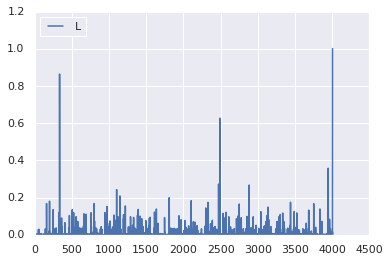

In [79]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

plt.plot(learned_batch, learned_loss)

plt.legend('L', ncol=2, loc='upper left');

In [54]:
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).double()

In [55]:
test = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)

In [81]:
correct = 0
total = 0
learned_loss = []
learned_batch = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.double() == labels).sum().item()
        learned_loss.append(correct)
        learned_batch.append(total)

print('Accuracy of the network on the {} inputs: {}'.format(
    X_test.shape[0], 100 * correct/total))


/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 28481 inputs: 99.82795547909133


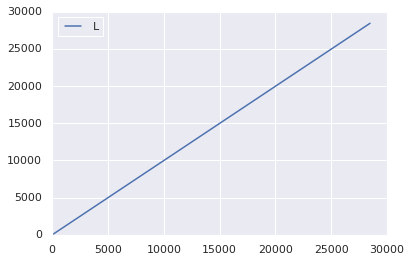

In [82]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

plt.plot(learned_batch, learned_loss)

plt.legend('L', ncol=2, loc='upper left');